<a href="https://colab.research.google.com/github/aaronli-uga/IIoT_Datahub/blob/master/AI_engine/AI_Engine_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# After running this code segment for the first time, you must restart the runtime, then run code again.

#!pip install 'influxdb-client[ciso]'
!pip install sklearn
!pip install -U scikit-learn --user
!pip install torch
!pip install skorch
!pip install torchinfo

#stable = False #True # Set to True for latest pip version or False for main branch in GitHub
#!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

!pip install nitime
!pip install PyDrive

!pip install influxdb-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from google.colab import drive

# This code connects Colab to my Google Drive

drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/PV_Data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
# Check For Colab Notebook connection to a GPU
# https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [22]:
# If connected to a GPU, output summary of the GPU
# https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=QMMqmdiYMkvi
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 25 04:18:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    49W / 400W |    630MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# This code ouputs runtime RAM information
# https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=QMMqmdiYMkvi
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [24]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pathlib import Path

#import influxdb_client
import skorch
#from tsai.all import *

import re
import pytz
from datetime import datetime

import enum
import os
import torch
from torch import optim
from torch.utils.data import DataLoader
#from data_loader import SiameseNetworkDataset
#from models import LSTM
#from customized_criterion import ContrastiveLoss
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.nn import functional as F

p = Path('.')
datapath = p / "Data/"


In [25]:
# Define interface functions

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_data(data_filename):
  data_file = np.load('/content/gdrive/MyDrive/Colab Notebooks/PV_Data/' + data_filename)
  return data_file

def extract_labels(dataset,X_start,X_end,y_column):
  if type(dataset) is np.ndarray:
    #print("numpy array")
    df = pd.DataFrame(dataset)
  elif type(dataset) is pd.core.frame.DataFrame:
    #print("data frame")
    df = dataset
  else:
    print("The dataset is not in a valid format")
    return
  #train = df_train.iloc[: , X_start:X_end].copy()
  train = df.iloc[: , X_start:X_end].copy()
  label = df.iloc[: , [y_column]].copy()
  X = train.to_numpy()
  y = label.to_numpy().flatten()
  return X, y

def split_dataset(dataset):
  x = data[:, :data.shape[1]-1]  # data
  y = data[:, -1] # label

  # normalization on input data x
  x = (x - x.mean(axis=0)) / x.std(axis=0) 

  # Use line below with PV_Data Only
  #x = np.delete(x, 799999, 1)  # delete second column of C

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return X_train, X_test, y_train, y_test

In [26]:
# Definging fit and predict

def uga_fit_predict(classifiers,names,X_train, X_test,y_train,y_test):
  figure = plt.figure(figsize=(27, 9))
  i = 1
  ds_cnt = 0

  x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
  y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5

  # just plot the dataset first
  cm = plt.cm.RdBu
  cm_bright = ListedColormap(["#FF0000", "#0000FF"])
  ax = plt.subplot(1, len(classifiers) + 1, i)
  if ds_cnt == 0:
    ax.set_title("Input data")
  # Plot the training points
  ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
  # Plot the testing points
  ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
  )
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xticks(())
  ax.set_yticks(())
  i += 1

  # iterate over classifiers
  for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)


        # Plot the training points
    ax.scatter(
      X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
      X_test[:, 0],
      X_test[:, 1],
      c=y_test,
      cmap=cm_bright,
      edgecolors="k",
      alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    if ds_cnt == 0:
      ax.set_title(name)
    ax.text(
      x_max - 0.3,
      y_min + 0.3,
      ("%.2f" % score).lstrip("0"),
      size=15,
      horizontalalignment="right",
    )
    i += 1

  plt.tight_layout()
  plt.show()
  return

In [27]:
#UGA FIt

def uga_fit(classifiers,names,X_train, y_train):

  x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5

  # iterate over classifiers
  for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
   
  return clf

In [28]:
#UGA PREDICT

def uga_predict(classifiers,names,X_train, X_test,y_train,y_test,clf):
  figure = plt.figure(figsize=(27, 9))
  i = 1
  ds_cnt = 0

  x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
  y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5

  # just plot the dataset first
  cm = plt.cm.RdBu
  cm_bright = ListedColormap(["#FF0000", "#0000FF"])
  ax = plt.subplot(1, len(classifiers) + 1, i)
  if ds_cnt == 0:
    ax.set_title("Input data")
  # Plot the training points
  ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
  # Plot the testing points
  ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
  )
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xticks(())
  ax.set_yticks(())
  i += 1

  # iterate over classifiers
  for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)

    #clf = make_pipeline(StandardScaler(), clf)
    #clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)


        # Plot the training points
    ax.scatter(
      X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
      X_test[:, 0],
      X_test[:, 1],
      c=y_test,
      cmap=cm_bright,
      edgecolors="k",
      alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    if ds_cnt == 0:
      ax.set_title(name)
    ax.text(
      x_max - 0.3,
      y_min + 0.3,
      ("%.2f" % score).lstrip("0"),
      size=15,
      horizontalalignment="right",
    )
    i += 1

  plt.tight_layout()
  plt.show()
  return

/root/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


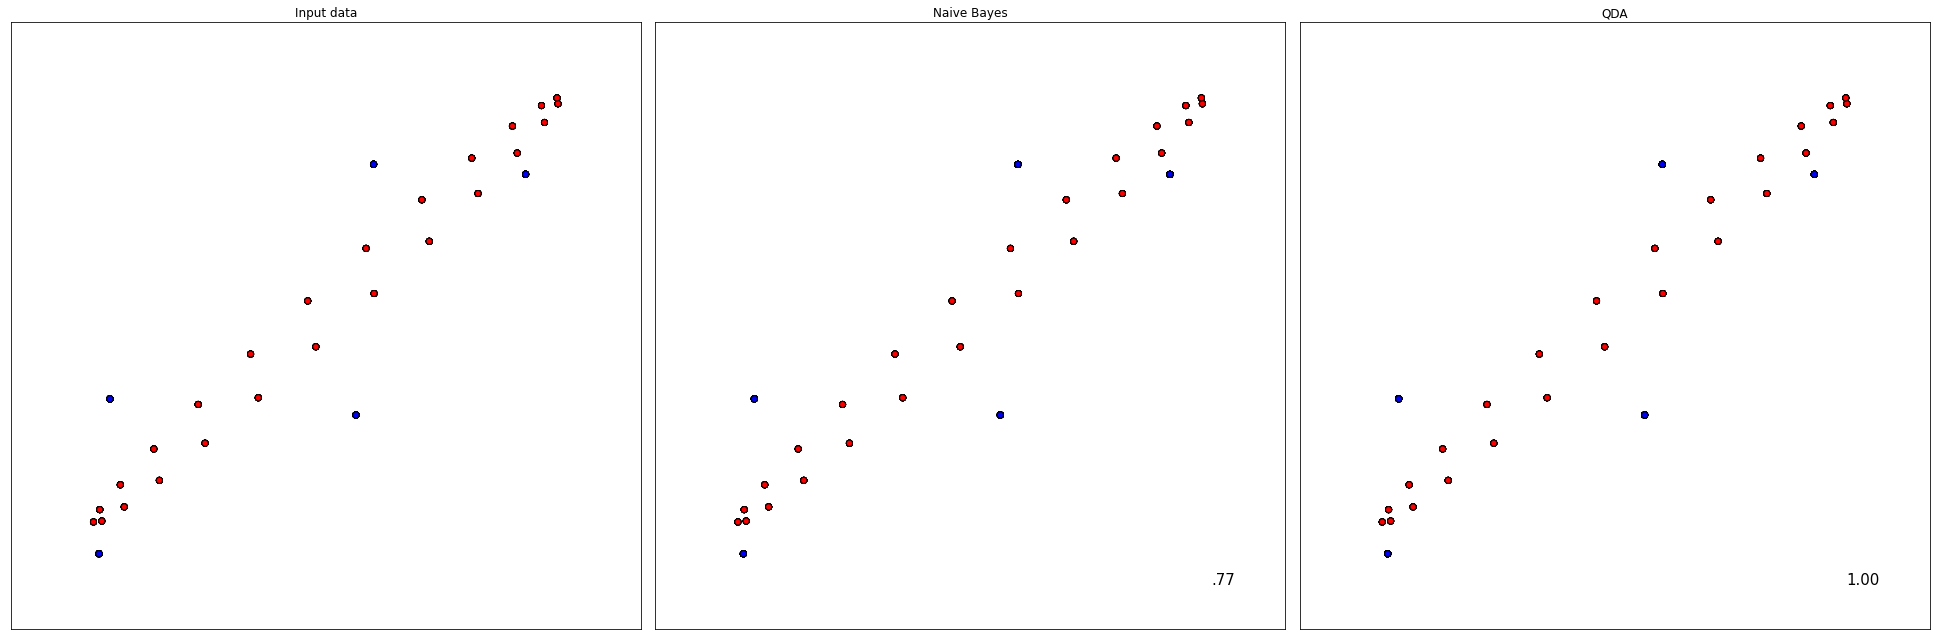

In [29]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# Modified by S. Coshatt for AI Engine

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
  #"Linear SVM",
  #"RBF SVM",
  #"Gaussian Process",
  #"Decision Tree",
  #"Random Forest",
  #"Neural Net",
  #"AdaBoost",
  "Naive Bayes",
  "QDA",
]

classifiers = [  
  #SVC(kernel="linear", C=0.025),
  #SVC(gamma=2, C=1),
  #GaussianProcessClassifier(1.0 * RBF(1.0)),
  #DecisionTreeClassifier(max_depth=5),
  #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
  #MLPClassifier(alpha=1, max_iter=1000),
  #AdaBoostClassifier(),
  GaussianNB(),
  QuadraticDiscriminantAnalysis(),
]

# Load Motor Data
#data = load_data('motor_data.npy')

# Load Demo Data
data = load_data('demo_data.npy')

# Split Data into train and test sets with labels
X_train, X_test, y_train, y_test = split_dataset(data)

# Run engine over classifiers
#uga_fit_predict(classifiers,names,X_train,X_test,y_train,y_test)

# Fit all classifiers
clf = uga_fit(classifiers,names,X_train,y_train)

# Predict on all classifiers
uga_predict(classifiers,names,X_train,X_test,y_train,y_test,clf)

In [30]:
# Setup Client

import influxdb_client
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS

token = "sSDR3urw9jxgsqq4q45MkUHZ4pqloQuKt_8MNTPoz8mEu4Nx4TRKXApZBTR-4QIz0XHcWrykWWm__9eoW9QLQQ=="
bucket = "theBucket"
org = "sevenSun"
url="http://172.20.79.200:8086"

client = influxdb_client.InfluxDBClient(
    url=url,
    token=token,
    org=org,
    debug = False
)

In [32]:
measurement = "waveform"
field = "current"
status = "normal" # to prompt the data's label

query_api = client.query_api()
query = f'from(bucket:"{bucket}")\
|> range(start: -1m)\
|> filter(fn:(r) => r._measurement == "{measurement}")\
|> filter(fn:(r) => r.status == "{status}")\
|> filter(fn:(r) => r._field == "{field}")'

result = query_api.query(org=org, query=query)
results = []
for table in result:
    for record in table.records:
        # results.append((record.get_field(), record.get_value()))
        results.append(record.get_value())
        print(record.get_value())


ConnectTimeoutError: ignored

In [38]:
# TROUBLESHOOTING CODE ONLY

print(type(clf))

#best_model.save('/content/gdrive/MyDrive/Coshatt-ECSE4420/Project/outputs/best_model.h5')

#print(type(clf[0]))

from sklearn import set_config
set_config(display='diagram')
# with display='diagram', simply use display() to see the diagram
display(clf)
# if desired, set display back to the default
set_config(display='text')

#clf[1].save('/content/gdrive/MyDrive/Colab Notebooks/Models/test_model.h5')

#import joblib

#joblib.dump(clf.best_estimator_, 'filename.pkl', compress = 1)

<class 'sklearn.pipeline.Pipeline'>


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('quadraticdiscriminantanalysis',
                 QuadraticDiscriminantAnalysis())])

In [13]:
pmu_data = load_data('motor_pmu.npy')
print(pmu_data.shape)

(20480000, 1)
